# Full Power Condenser Fault Detection

This is a series of simple Tensorflow Keras models to exhibit the effectiveness of modeling fault detection within reactors. Time series and regression models were used to determine what goes into creating a fault. This is a preliminary model which will be reevaluated and redone for both the steam generator and the condenser at multiple powers. Currently, this system is looking at transients. Data will be added to look at steam generator and condenser faults in the future.

In [1]:
# Change runtime to GPU!

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

2022-03-21 14:12:02.336439: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Data preprocessing and pruning

In [2]:
full_100_run = pd.read_csv('https://gitlab.com/lambpati/asherah-training/-/raw/main/normal100.csv')
transient_run = pd.read_csv('https://gitlab.com/lambpati/asherah-training/-/raw/main/Transients.csv')

In [3]:
full_100_run.head()

Time  AF_LetdownFlow  AF_LetdownValvePos  AF_MakeupFLow  \
0    0 sec             0.0                 0.0              0   
1  0.1 sec             0.0                 0.0              0   
2  0.2 sec             0.0                 0.0              0   
3  0.3 sec             0.0                 0.0              0   
4  0.4 sec             0.0                 0.0              0   

   AF_MakeupValvePos  CC_PumpFlow  CC_PumpInletTemp  CC_PumpOutletTemp  \
0                0.0  168320.0000            298.15         302.680000   
1                0.0  168320.0000            298.15         302.678077   
2                0.0  168342.8761            298.15         302.676769   
3                0.0  168380.5607            298.15         302.675881   
4                0.0  168427.4973            298.15         302.675276   

   CC_PumpSpeed  CC_PumpTemp  ...  SG2_OutletSteamTemp  SG2_OutletTemp  \
0    100.000000       333.15  ...           553.083239      562.386235   
1    100.000000       333.15  ...           553.083232      562.728671   
2    100.013591       333.15  ...           553.081801      562.702210   
3    100.035979       333.15  ...           553.079406      562.614108   
4    100.063865       333.15  ...           553.076155      562.724770   

     SG2_Press  SG2_SteamT  SG2_WaterTemp  TB_InSteamFlow  TB_InSteamPress  \
0  6410000.000  553.083239     553.083239     1522.220000      6410000.000   
1  6409999.315  553.083232     553.083232     1522.216688      6409999.315   
2  6409860.903  553.081801     553.081801     1522.197916      6409860.903   
3  6409629.261  553.079406     553.079406     1522.147707      6409629.261   
4  6409314.857  553.076155     553.076155     1522.054938      6409314.858   

   TB_OutSteamPress    TB_Speed  TB_SpeedCtrlValvePos  
0       5199.600000  157.079633            100.000000  
1       5226.781640  157.079633             99.999931  
2       5245.464677  157.079633             99.986090  
3       5258.238118  157.079633             99.962879  
4       5266.909097  157.079633             99.931316  

[5 rows x 96 columns]

In [4]:
# Prune full dataset to just condenser values
good_run = full_100_run#[['CD_CondTemp', 'CD_InSteamFlow', 'CD_Level', 'CD_OutCondFlow', 'CD_Press', 'CD_SteamTemp']]

In [5]:
# Set all values from full dataset to 'True' for steadystate
good_run = good_run.assign(Steady = 1)

In [6]:
# Strip units
good_run['Time'] = good_run['Time'].str.replace(r'\D', '')

/tmp/ipykernel_50370/1393417609.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  good_run['Time'] = good_run['Time'].str.replace(r'\D', '')


<AxesSubplot:xlabel='Time'>

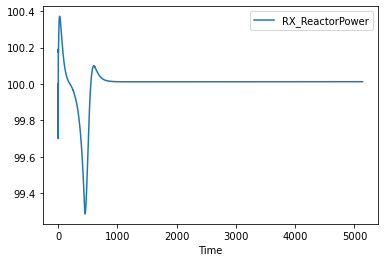

In [9]:
good_run.plot('Time', 'RX_ReactorPower')

In [7]:
# Prune fault dataset to just condenser values
fault_cond = transient_run#[['CD_CondTemp', 'CD_InSteamFlow', 'CD_Level', 'CD_OutCondFlow', 'CD_Press', 'CD_SteamTemp']]

In [8]:
# Set all values from fault data set to 'False' for steadystate 
fault_cond = fault_cond.assign(Steady = 0)

In [9]:
fault_cond['Time'] = fault_cond['Time'].str.replace(r'\D', '') 

/tmp/ipykernel_50370/732791955.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  fault_cond['Time'] = fault_cond['Time'].str.replace(r'\D', '')


<AxesSubplot:xlabel='Time'>

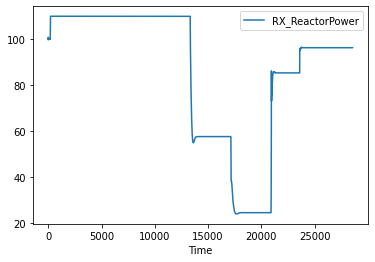

In [44]:
fault_cond.plot('Time', 'RX_ReactorPower')

In [10]:
# Concat the steady data with fault data
df = pd.concat([good_run, fault_cond])
df.shape

(337017, 97)

In [46]:
# Check to make sure true values still exist
True in df['Steady']

True

In [47]:
# Check to make sure false values still exist
False in df['Steady']

True

In [11]:
# Check to make sure there are no NaN values
df.isnull().values.any()
df.dropna()

Time  AF_LetdownFlow  AF_LetdownValvePos  AF_MakeupFLow  \
0           0             0.0                 0.0              0   
1          01             0.0                 0.0              0   
2          02             0.0                 0.0              0   
3          03             0.0                 0.0              0   
4          04             0.0                 0.0              0   
...       ...             ...                 ...            ...   
285655  28566             0.0                 0.0              0   
285656  28566             0.0                 0.0              0   
285657  28566             0.0                 0.0              0   
285658  28566             0.0                 0.0              0   
285659  28566             0.0                 0.0              0   

        AF_MakeupValvePos    CC_PumpFlow  CC_PumpInletTemp  CC_PumpOutletTemp  \
0                     0.0  168320.000000            298.15         302.680000   
1                     0.0  168320.000000            298.15         302.678077   
2                     0.0  168342.876100            298.15         302.676769   
3                     0.0  168380.560700            298.15         302.675881   
4                     0.0  168427.497300            298.15         302.675276   
...                   ...            ...               ...                ...   
285655              100.0  131758.896497            298.15         302.891554   
285656              100.0  131758.896463            298.15         302.891554   
285657              100.0  131758.896421            298.15         302.891554   
285658              100.0  131758.896388            298.15         302.891554   
285659              100.0  131758.896347            298.15         302.891554   

        CC_PumpSpeed  CC_PumpTemp  ...  SG2_OutletTemp     SG2_Press  \
0         100.000000       333.15  ...      562.386235  6.410000e+06   
1         100.000000       333.15  ...      562.728671  6.409999e+06   
2         100.013591       333.15  ...      562.702210  6.409861e+06   
3         100.035979       333.15  ...      562.614108  6.409629e+06   
4         100.063865       333.15  ...      562.724770  6.409315e+06   
...              ...          ...  ...             ...           ...   
285655     78.278812       333.15  ...      556.406144  5.448701e+06   
285656     78.278812       333.15  ...      536.441052  5.448193e+06   
285657     78.278812       333.15  ...      556.406138  5.448701e+06   
285658     78.278812       333.15  ...      536.440987  5.448193e+06   
285659     78.278812       333.15  ...      556.406143  5.448701e+06   

        SG2_SteamT  SG2_WaterTemp  TB_InSteamFlow  TB_InSteamPress  \
0       553.083239     553.083239     1522.220000     6.410000e+06   
1       553.083232     553.083232     1522.216688     6.409999e+06   
2       553.081801     553.081801     1522.197916     6.409861e+06   
3       553.079406     553.079406     1522.147707     6.409629e+06   
4       553.076155     553.076155     1522.054938     6.409315e+06   
...            ...            ...             ...              ...   
285655  542.518686     542.518686     1167.372288     5.448499e+06   
285656  542.512730     542.512730     1167.372326     5.448501e+06   
285657  542.518686     542.518686     1167.372289     5.448499e+06   
285658  542.512730     542.512730     1167.372329     5.448501e+06   
285659  542.518686     542.518686     1167.372293     5.448499e+06   

        TB_OutSteamPress    TB_Speed  TB_SpeedCtrlValvePos  Steady  
0            5199.600000  157.079633            100.000000       1  
1            5226.781640  157.079633             99.999931       1  
2            5245.464677  157.079633             99.986090       1  
3            5258.238118  157.079633             99.962879       1  
4            5266.909097  157.079633             99.931316       1  
...                  ...         ...                   ...     ...  
285655       5199.599945  157.

## Autokeras Time Series Forecaster

In [12]:
# Make target if system is steady state or not
target = df[['Steady']]

In [13]:
# Drop 'Steady' for dataframe
df = df.drop(['Steady'],axis=1)

In [17]:
# Split data into training, testing, and validation
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=1/5, shuffle=False)
X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train, y_train, test_size=1/4, shuffle=False)

In [89]:
X_train_tr.shape

(202209, 96)

In [18]:
# Scale data for keras
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
data_X = X_train_tr[:].astype("float64")
data_X_v = X_train_v[:].astype("float64")
data_y = y_train_tr[:].astype("float64")
data_y_v = y_train_v[:].astype("float64")
data_X_test = X_test[:].astype("float64")
data_y_test = y_test[:].astype("float64")

In [22]:
import autokeras as ak
clf = ak.TimeseriesForecaster(
    lookback=lookback,
    predict_from=predict_from,
    predict_until=predict_until,
    max_trials=10,
    objective="MSE"
)
# Train the TimeSeriesForecaster with train data
history = clf.fit(
    x=data_X,
    y=data_y,
    validation_data=(data_X_v, data_y_v),
    batch_size=32,
    epochs=10,
)

# print(predictions.shape)

ModuleNotFoundError: No module named 'autokeras'

In [ ]:
# Evaluate the best model with testing data.
clf.evaluate(X_test, y_test)

In [75]:
# Predict with the best model(includes original training data).
#samples = np.array(X_test)
#predictions = clf.predict(samples)

In [74]:
# Plot the best fitting model
#plt.plot(history.epoch, history.history["loss"], 'g', label="Training loss")
#plt.title('Loss for Condenser Training Data')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()

## Create an RNN for fault detection (wrt time)

In [26]:
# Reshape the input into LSTM compatible (3D) which should have samples, timesteps & features
X_train_tr = np.expand_dims(X_train_tr, 1)
X_train_v = np.expand_dims(X_train_v, 1)
X_test = np.expand_dims(X_test, 1)

def net_arch(net_in, n_vocab):
    model = keras.models.Sequential()

    # 256 - dimensionality of the output space
    model.add(
        keras.layers.LSTM(
            256,
            input_shape=net_in.shape[1:],
            return_sequences=True,
            recurrent_dropout=0.3,
        )
    )
    model.add(keras.layers.LSTM(256))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(n_vocab))
    model.add(keras.layers.Activation("sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[keras.metrics.MSE])
    return model

arch = net_arch(X_train, 1)

call = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
arch_history = arch.fit(
    x=X_train,
    y=y_train,
    callbacks=[call],
    validation_data=(X_train_v, y_train_v),
    batch_size=32,
    epochs=10,
)

ValueError: Input 0 of layer lstm_3 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 96)

In [ ]:
# Evaluate the best model with testing data.
clf.evaluate(X_test, y_test)

## AutoKeras StructuredDataClassifier

In [14]:
df = df.drop(['Time'], axis=1)

In [15]:
# Split data into training, testing, and validation
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=1/5, shuffle=False)
X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train, y_train, test_size=1/4, shuffle=False)

In [25]:
# It tries 10 different models.
class_clf = ak.StructuredDataClassifier(overwrite=True, max_trials=10)
# Feed the structured data classifier with training data.
class_clf.fit(X_train, y_train, epochs=100)
# Predict with the best model.
predicted_y = clf.predict(X_test)


Trial 10 Complete [00h 02m 42s]
val_accuracy: 0.888394296169281

Best val_accuracy So Far: 0.8888285756111145
Total elapsed time: 00h 22m 38s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1788 - accuracy: 0.8836
Epoch 2/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1612 - accuracy: 0.8846
Epoch 3/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1605 - accuracy: 0.8853
Epoch 4/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1603 - accuracy: 0.8840
Epoch 5/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1600 - accuracy: 0.8852
Epoch 6/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1600 - accuracy: 0.8853
Epoch 7/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1598 - accuracy: 0.8860
Epoch 8/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1598 - accuracy: 0.8857
Epoch 9/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1597 - accuracy: 0.8863
Epoch 10/100
1443/1443 [==============================] - 3s 2ms/step - l

INFO:tensorflow:Assets written to: ./structured_data_classifier/best_model/assets


361/361 [==============================] - 1s 2ms/step


In [26]:
class_clf.evaluate(X_test, y_test)

361/361 [==============================] - 1s 2ms/step - loss: 0.1605 - accuracy: 0.8861


[0.16050127148628235, 0.8860781192779541]

In [ ]:
plt.plot(y_test, predicted_y)

## Keras Tuner Hyperparameter Tuned Artificial Neural Network

In [28]:
import keras_tuner as kt

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(
        hp.Int('units', min_value=50, max_value=200, step=20), kernel_initializer="lecun_normal",
        activation='selu'))
    model.add(keras.layers.Dense(
        hp.Int('units_2', min_value=50, max_value=200, step=20),   # note different name
        kernel_initializer="lecun_normal", activation='selu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(loss=keras.losses.BinaryCrossentropy(), 
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.BinaryAccuracy()])
    return model

In [29]:
tuner2 = kt.Hyperband(build_model,
                     objective='val_binary_accuracy',
                     overwrite=True  # to build a second tuner after the first (it will keep the first in memory and give an error otherwise)
                     #max_epochs=20,
                     )

In [30]:
# 4. Fit (ie train) on data, validation split is established here as 0.10
es_callback = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True,
                                                  verbose=1, monitor="val_loss")
tuner2.search(X_train_tr, y_train_tr, epochs=35, validation_data=(X_train_v, y_train_v),
             callbacks=[es_callback])

Trial 237 Complete [00h 01m 11s]
val_binary_accuracy: 0.4440092444419861

Best val_binary_accuracy So Far: 1.0
Total elapsed time: 03h 10m 36s
INFO:tensorflow:Oracle triggered exit


In [31]:
best_hps2 = tuner2.get_best_hyperparameters()
hyper_model2 = tuner2.hypermodel.build(best_hps2[0])
hyper_model2.fit(X_train_tr, y_train_tr, epochs=50, validation_data=(X_train_v, y_train_v),
             callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
6320/6320 [==============================] - 12s 2ms/step - loss: 0.0064 - binary_accuracy: 0.9971 - val_loss: 0.0030 - val_binary_accuracy: 0.9985
Epoch 2/50
6320/6320 [==============================] - 12s 2ms/step - loss: 4.6733e-05 - binary_accuracy: 1.0000 - val_loss: 2.8576e-06 - val_binary_accuracy: 1.0000
Epoch 3/50
6320/6320 [==============================] - 12s 2ms/step - loss: 3.1694e-05 - binary_accuracy: 1.0000 - val_loss: 1.4749e-32 - val_binary_accuracy: 1.0000
Epoch 4/50
6320/6320 [==============================] - 12s 2ms/step - loss: 1.4303e-04 - binary_accuracy: 1.0000 - val_loss: 1.3263e-15 - val_binary_accuracy: 1.0000
Epoch 5/50
6320/6320 [==============================] - 12s 2ms/step - loss: 1.4429e-05 - binary_accuracy: 1.0000 - val_loss: 9.0589 - val_binary_accuracy: 0.4434
Epoch 6/50
6320/6320 [==============================] - 12s 2ms/step - loss: 1.2137e-12 - binary_accuracy: 1.0000 - val_loss: 10.7660 - val_binary_accuracy: 0.4433
Epoch 7/50
63

In [32]:
hyper_model2.evaluate(X_test, y_test)

2107/2107 [==============================] - 2s 889us/step - loss: 1.3428e-10 - binary_accuracy: 1.0000


[1.342834593520692e-10, 1.0]

In [33]:
predicted_y2 = hyper_model2.predict(X_test)

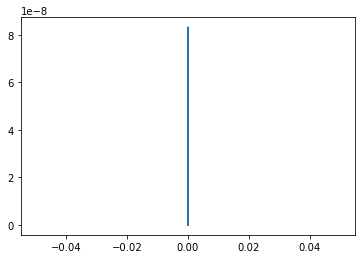

In [34]:
plt.plot(y_test, predicted_y2)